This project uses the ARCH and GARCH (2,2) model to study the volatility of the S&P options. The ARCH model captures periods of high and volatility together. The real life stock volatilities are not constant and certain events like a war and new regulations of trades between countries can impact the volatilities of the stocks. Therefore, the accounting for high volatility periods in the stock data becomes could offer a better risk management and better trading strategies. The figures and program below demonstrate the S&P 100 stock options.

The parameters: 

The stock data used: S&P

Duration:

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import datetime
import scipy.stats as stats
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.stats import shapiro
from scipy.optimize import brentq
from scipy.integrate import quad
from dateutil import parser
from dateutil.tz import tzutc
from arch import arch_model
from tqdm import trange
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


sns.set_style('darkgrid')

## First we plot the usual volatility if S&P 500.

In [18]:
spy = yf.download('SPY', start = '2010-01-01')

stock_symbol = 'SPY'
ticker = yf.Ticker(stock_symbol)
stock_data = yf.download(stock_symbol, period = '1d', interval = '1m')

expirations = ticker.options

C:\Users\anshu\AppData\Local\Temp\ipykernel_27296\1936530848.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy = yf.download('SPY', start = '2010-01-01')
[*********************100%***********************]  1 of 1 completed
C:\Users\anshu\AppData\Local\Temp\ipykernel_27296\1936530848.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(stock_symbol, period = '1d', interval = '1m')
[*********************100%***********************]  1 of 1 completed


In [21]:
y=ticker.option_chain('2025-11-14').calls

In [22]:
y

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,SPY251114C00400000,2025-11-07 19:01:45+00:00,400.0,266.25,270.65,273.33,-17.320007,-6.107842,10,1,1.837891,True,REGULAR,USD
1,SPY251114C00430000,2025-11-05 16:03:27+00:00,430.0,248.04,241.97,242.24,0.000000,0.000000,1,800,1.636721,True,REGULAR,USD
2,SPY251114C00435000,2025-10-31 16:46:38+00:00,435.0,247.15,235.65,238.36,0.000000,0.000000,3,3,1.575686,True,REGULAR,USD
3,SPY251114C00490000,2025-10-31 13:33:29+00:00,490.0,195.25,180.74,183.40,0.000000,0.000000,2,5,1.204594,True,REGULAR,USD
4,SPY251114C00495000,2025-10-17 14:11:03+00:00,495.0,168.40,175.75,178.42,0.000000,0.000000,2,2,1.174076,True,REGULAR,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,SPY251114C00765000,2025-11-03 20:57:03+00:00,765.0,0.01,0.01,0.02,0.000000,0.000000,110,4058,0.330085,False,REGULAR,USD
114,SPY251114C00770000,2025-11-07 21:04:06+00:00,770.0,0.01,0.01,0.02,0.000000,0.000000,3,5181,0.343757,False,REGULAR,USD
115,SPY251114C00780000,2025-11-07 21:14:05+00:00,780.0,0.01,0.00,0.01,0.000000,0.000000,6,1559,0.351569,False,REGULAR,USD
116,SPY251114C00785000,2025-11-06 21:14:34+00:00,785.0,0.01,0.00,0.01,0.000000,0.000000,1134,1275,0.367194,False,REGULAR,USD


In [23]:
plt.plot(y[lastPrice])

NameError: name 'lastPrice' is not defined

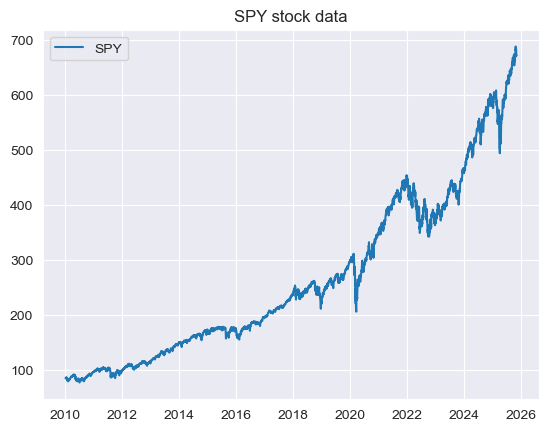

In [4]:
plt.plot(spy['Close','SPY'], label = 'SPY')

plt.title('SPY stock data')
plt.legend()
plt.show()

## Usual vs ARCH volatility

In [5]:
# Usual volatility turns out to be constant.
spy_usual_return = spy['Close','SPY'].pct_change()+1

spy_volatility = np.std(np.log(spy_usual_return))*np.sqrt(252)

In [6]:
spy_volatility

np.float64(0.17283296369248477)

### Now we plot the varied volatilities of the above stocks using GARCH model. To use the GARCH fit, we need to first plot the partial autocorrection graph.

Text(0.5, 1.0, 'S&P Returns')

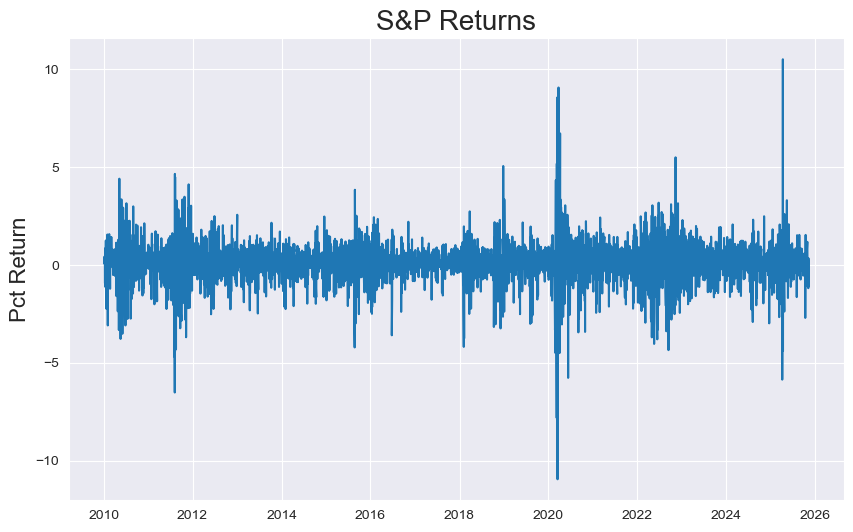

In [7]:
spy_returns= 100 * spy['Close','SPY'].pct_change().dropna()

plt.figure(figsize=(10,6))
plt.plot(spy_returns)
plt.ylabel('Pct Return', fontsize=16)
plt.title('S&P Returns', fontsize=20)

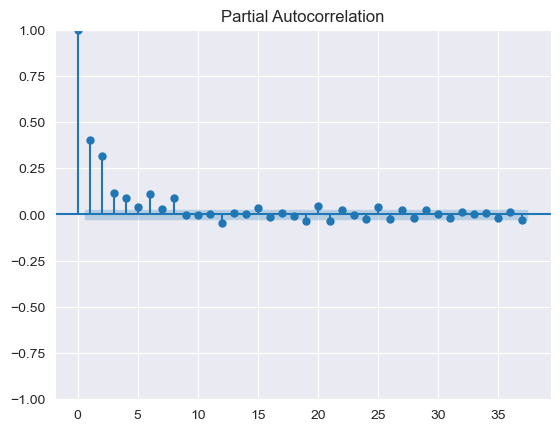

In [8]:
plot_pacf(spy_returns**2)
plt.show()

In [9]:
model = arch_model(spy_returns, p=2, q=2)

In [10]:
model_fit = model.fit()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 37796.649936223825
Iteration:      2,   Func. Count:     20,   Neg. LLF: 18510.93365646134
Iteration:      3,   Func. Count:     32,   Neg. LLF: 7672.290534696991
Iteration:      4,   Func. Count:     41,   Neg. LLF: 7154.616162486471
Iteration:      5,   Func. Count:     50,   Neg. LLF: 5314.529303854182
Iteration:      6,   Func. Count:     59,   Neg. LLF: 5117.0849831599135
Iteration:      7,   Func. Count:     67,   Neg. LLF: 5123.953406646767
Iteration:      8,   Func. Count:     75,   Neg. LLF: 5115.152405377756
Iteration:      9,   Func. Count:     82,   Neg. LLF: 5118.841271057958
Iteration:     10,   Func. Count:     91,   Neg. LLF: 5116.057887221454
Iteration:     11,   Func. Count:     99,   Neg. LLF: 5114.426030893989
Iteration:     12,   Func. Count:    106,   Neg. LLF: 5114.416575575249
Iteration:     13,   Func. Count:    113,   Neg. LLF: 5114.415707572374
Iteration:     14,   Func. Count:    120,   Neg. LLF: 5114.415

In [11]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:       ('Close', 'SPY')   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5114.42
Distribution:                  Normal   AIC:                           10240.8
Method:            Maximum Likelihood   BIC:                           10278.6
                                        No. Observations:                 3987
Date:                Sat, Nov 08 2025   Df Residuals:                     3986
Time:                        14:35:42   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0890  1.189e-02      7.492  6.785e-14 [6.575e-02,  0.112]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.0704  3.420e-02      2.060  3.944e-02  [3.405e-03,  0.137]
alpha[1]       0.1416  6.382e-02      2.218  2.653e-02  [1.649e-02,  0.267]
alpha[2]       0.1636  8.828e-02      1.854  6.379e-02 [-9.387e-03,  0.337]
beta[1]    7.4488e-17      1.087  6.854e-17      1.000    [ -2.130,  2.130]
beta[2]        0.6341      0.914      0.694      0.488    [ -1.158,  2.426]
===========================================================================

Covariance estimator: robust
"""

In [12]:
rolling_predictions = []
test_size = 365*5

for i in range(test_size):
    train = spy_returns[:-(test_size-i)]
    model = arch_model(train, p=2, q=2)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

In [13]:
rolling_predictions = pd.Series(rolling_predictions, index=spy_returns.index[-365*5:])

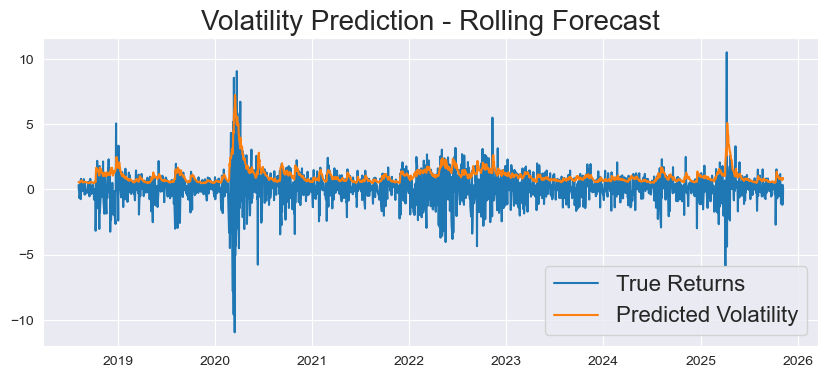

In [14]:
plt.figure(figsize=(10,4))
true, = plt.plot(spy_returns[-365*5:])
preds, = plt.plot(rolling_predictions)
plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted Volatility'], fontsize=16)

## Computing option pricing for S&P 500 ETF

In [15]:
stock_symbol = 'SPY'
ticker = yf.Ticker(stock_symbol)
stock_data = yf.download(stock_symbol, period = '1d', interval = '1m')

expirations = ticker.options

C:\Users\anshu\AppData\Local\Temp\ipykernel_27296\184881483.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(stock_symbol, period = '1d', interval = '1m')
[*********************100%***********************]  1 of 1 completed


In [16]:
ticker.option_chain('2025-11-14').calls

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,SPY251114C00400000,2025-11-07 19:01:45+00:00,400.0,266.25,270.65,273.33,-17.320007,-6.107842,10,1,1.837891,True,REGULAR,USD
1,SPY251114C00430000,2025-11-05 16:03:27+00:00,430.0,248.04,241.97,242.24,0.000000,0.000000,1,800,1.636721,True,REGULAR,USD
2,SPY251114C00435000,2025-10-31 16:46:38+00:00,435.0,247.15,235.65,238.36,0.000000,0.000000,3,3,1.575686,True,REGULAR,USD
3,SPY251114C00490000,2025-10-31 13:33:29+00:00,490.0,195.25,180.74,183.40,0.000000,0.000000,2,5,1.204594,True,REGULAR,USD
4,SPY251114C00495000,2025-10-17 14:11:03+00:00,495.0,168.40,175.75,178.42,0.000000,0.000000,2,2,1.174076,True,REGULAR,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,SPY251114C00765000,2025-11-03 20:57:03+00:00,765.0,0.01,0.01,0.02,0.000000,0.000000,110,4058,0.330085,False,REGULAR,USD
114,SPY251114C00770000,2025-11-07 21:04:06+00:00,770.0,0.01,0.01,0.02,0.000000,0.000000,3,5181,0.343757,False,REGULAR,USD
115,SPY251114C00780000,2025-11-07 21:14:05+00:00,780.0,0.01,0.00,0.01,0.000000,0.000000,6,1559,0.351569,False,REGULAR,USD
116,SPY251114C00785000,2025-11-06 21:14:34+00:00,785.0,0.01,0.00,0.01,0.000000,0.000000,1134,1275,0.367194,False,REGULAR,USD


In [ ]:
## Randomly generated stock paths as Geometric Brownian Motions

def GBM_paths(S0, sigma, t, r, mu, n_sims, n_steps):
    
    dt = t/n_steps
    noise = np.random.normal(loc = 0, scale = 1, size = (n_sims, n_steps))
    log_returns = (mu+r-sigma**2*(0.5))*dt + sigma*np.sqrt(dt)*noise
    exponent = np.cumsum(log_returns, axis = 1)
    paths = S0*np.exp(exponent)
    paths_with_start = np.insert(paths, 0, S0, axis = 1)

    return paths_with_start

##Black-Scholes Functions
def bs_call(S0, K, sigma, t, r):
    '''
    Black-Scholes Call Option formula
    
    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    t: Time to expiration (years)
    r: Risk-free Interest rate
    
    
    Return:
    Black-Scholes value of call option (float)
    '''
    
    d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))
    
    d2 = d1 - sigma*np.sqrt(t)
    
    
    call_value = S0*norm.cdf(d1) - K*np.exp(-r*t)*norm.cdf(d2)
    
    
    return call_value
    


def bs_put(S0, K, sigma, t, r):
    '''
    Black-Scholes Put Option formula
    
    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    t: Time to expiration (years)
    r: Risk-free Interest rate
    
    
    Return:
    Black-Scholes value of put option (float)
    '''
    
    d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))
    
    d2 = d1 - sigma*np.sqrt(t)
    
    
    put_value = -S0*norm.cdf(-d1) + K*np.exp(-r*t)*norm.cdf(-d2)
    
    
    return put_value


def bs_call_delta(S0, K, sigma, t, r):

    
    
    d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))
    
    
    return norm.cdf(d1)



def bs_put_delta(S0, K, sigma, t, r):
  
    d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))
    
    
    return -1 + norm.cdf(d1)

